# Simpsons Characters Recognition
Dataset with nearly 21000 labeled images of characters from the Simpsons and a set of 990 labelled test images.<p>
**Source:** https://www.kaggle.com/ymalov/simpsons<p>
    The project consists of three Jupyter Notebooks and two Python files
    1. Jupyter Notebook for Preprocessing (this one)
    2. Jupyter Notebook for training of the Neuronal Network (actual training happend in Google Colab)
    3. Jupyter Notebook for testing the predictions of the Network
 
One Python file includes auxillary functions treating the images and one contains functions and a class for the defining the neuronal network
## Preprocessing
    - First glance at the images
    - Check aspect ratio and resolution
    - Distribution of characters in the images
    - Decision which data to use
    - Decision how to treat the data

In [1]:
#Import libaries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import sys
import pandas as pd
from skimage import io, exposure, color, transform
import json

#import custom functions
import simpsons_utils as su

In [2]:
#Path to train and test datat
train_path = './simpsons_dataset/'
test_path = './simpsons_testset/'

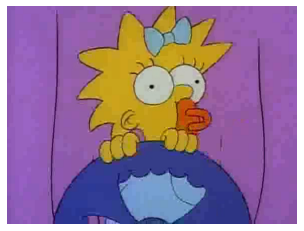

In [3]:
#Show one image
plt.imshow(io.imread('./simpsons_dataset/maggie_simpson/pic_0006.jpg'))
plt.axis('off');

### First glance at images

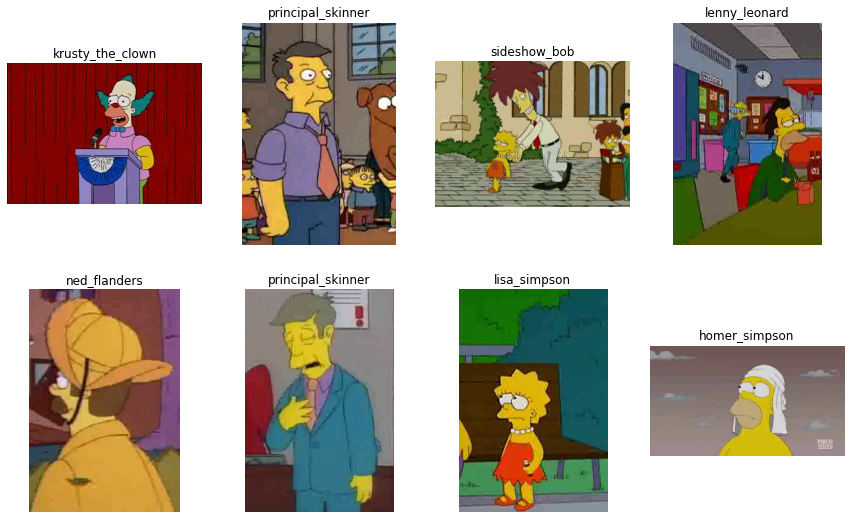

In [4]:
#List of all characters which are included in the dataset
character_list = ['abraham_grampa_simpson', 'groundskeeper_willie', 'ned_flanders',
                  'agnes_skinner', 'homer_simpson', 'nelson_muntz', 
                  'apu_nahasapeemapetilon', 'kent_brockman', 'otto_mann',
                  'barney_gumble', 'krusty_the_clown', 'patty_bouvier',
                  'bart_simpson', 'lenny_leonard', 'principal_skinner',
                  'carl_carlson', 'lionel_hutz', 'professor_john_frink',
                  'charles_montgomery_burns', 'lisa_simpson', 'rainier_wolfcastle',
                 'chief_wiggum', 'maggie_simpson', 'ralph_wiggum',
                 'cletus_spuckler', 'marge_simpson', 'selma_bouvier',
                 'comic_book_guy', 'martin_prince', 'sideshow_bob',
                 'disco_stu', 'mayor_quimby', 'sideshow_mel',
                 'edna_krabappel', 'milhouse_van_houten', 'snake_jailbird',
                 'fat_tony', 'miss_hoover', 'troy_mcclure',
                 'gil', 'moe_szyslak', 'waylon_smithers']

#Read path and names to all image files
image_files, labels = su.create_train_image_list(train_path, character_list)

#Load a couple of images 
su.show_random_images(image_files, labels, character_list)

- images have different shapes
- images have different resolutions
- images are in RGB colorspace

### Aspect ratio and resolution

In [5]:
#Read resolution of all images and aspect ratios
res = np.zeros((image_files.shape[0], 2))
aspect = np.zeros(image_files.shape)

for idx, img in enumerate(image_files):
    tmp_img = io.imread(img)
    res[idx, 0], res[idx, 1] = tmp_img.shape[0], tmp_img.shape[1] 
    aspect[idx] = tmp_img.shape[0] / tmp_img.shape[1]

[(240.0, 1100.0), (240.0, 2000.0)]

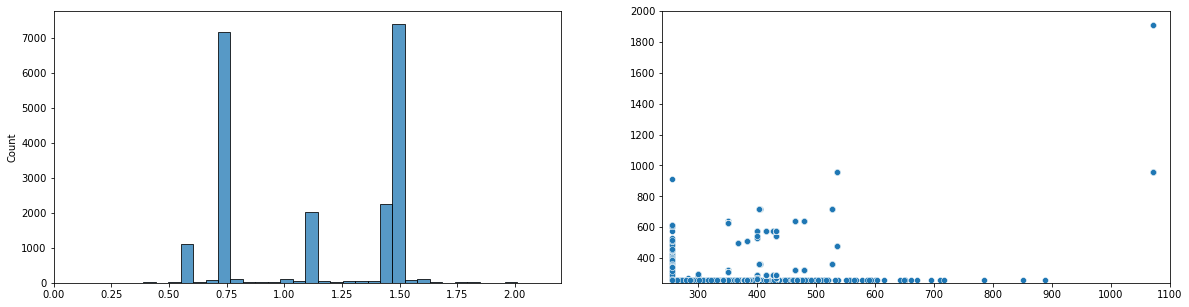

In [6]:
#plot aspect ratios and resolutions
fig, axs = plt.subplots(ncols=2, figsize=(20,5))

#aspect plot
asp_plot = sns.histplot(data=aspect, ax=axs[0])
asp_plot.set(xlim=(0, 2.2))

#resolution plot
res_plot = sns.scatterplot(x=res[:,0], y=res[:,1], ax=axs[1])
res_plot.set(xlim=(240, 1100), ylim=(240, 2000))

- most images have aspect ratios of 0.75 are 1.5
- there is no preference between ladscape and horizontal images
- Scaling to aspect ratio 1.0, could lead to distortions.
- Should scale to aspect ration 1.5.
    - Images with aspect ratio smaller 1 need to be rotated first
- Most images have an resolution of around 250px in one direction
- The second direction ranges from 250px to around 700px (with outliers of up to 2000px)<br>
<br>
- it will be easier to use an aspect ratio of 1.0 because it preferes not one orientation over another and there is not need for rotation images

### Distribution of characters in images

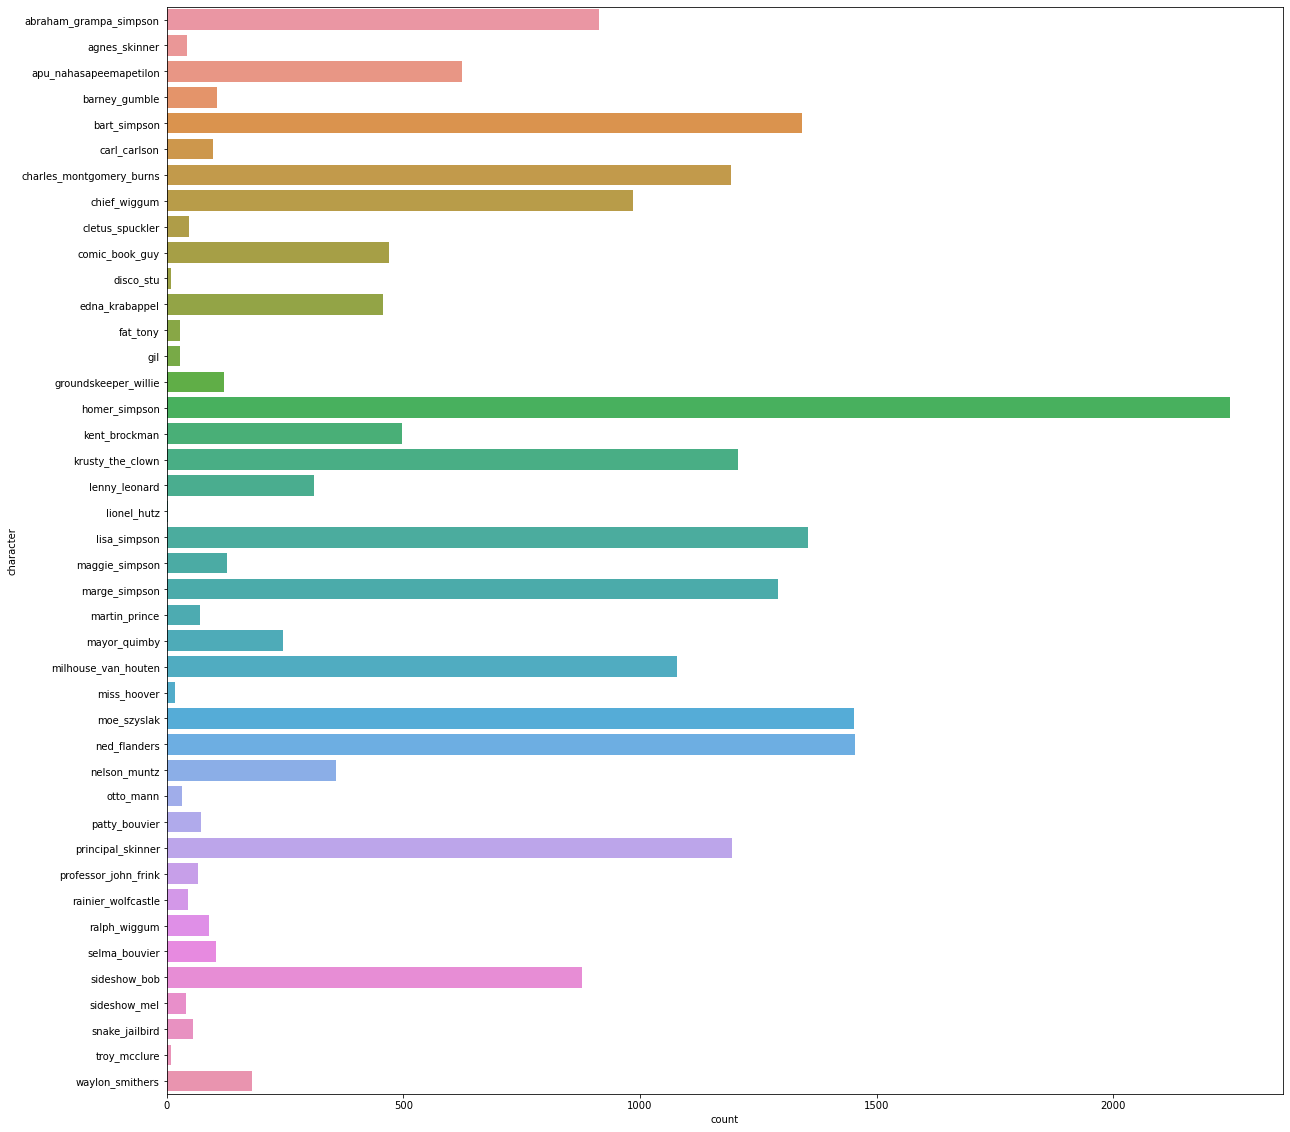

In [7]:
#Histogramm with number of images for each character
df_tmp = pd.DataFrame({'character' : np.asarray(character_list)[labels],
                      'count' : labels})
df_tmp = df_tmp.groupby('character', as_index=False).count()
plt.figure(figsize=(20, 20))
sns.barplot(data=df_tmp, y='character', x='count');

- There are many characters which have only a small amount of samples.
<br>Possible solution:
- Drop characters with < 200 images, so we can split the images into large enough train, test, and validate data
- Rotate images, mirror images, rescale, crop, for creating more artifical data
<br><br>
- for first try we will just ignore characters with a small amount of data (threshold will be 200 images)

In [8]:
#extract characters with > 200 images and reload labels and image_list
char_list_reduced = list(df_tmp.loc[df_tmp['count'] > 200, 'character'].values)
image_files, labels = su.create_train_image_list(train_path, char_list_reduced)

print(f"There are {len(char_list_reduced)} left in the character list")

There are 20 left in the character list


In [9]:
#Save characterlist reduced to later use by the ML-Modells
with open('char_list_reduced.json', 'w') as f:
    json.dump(char_list_reduced, f)

### Image Settings

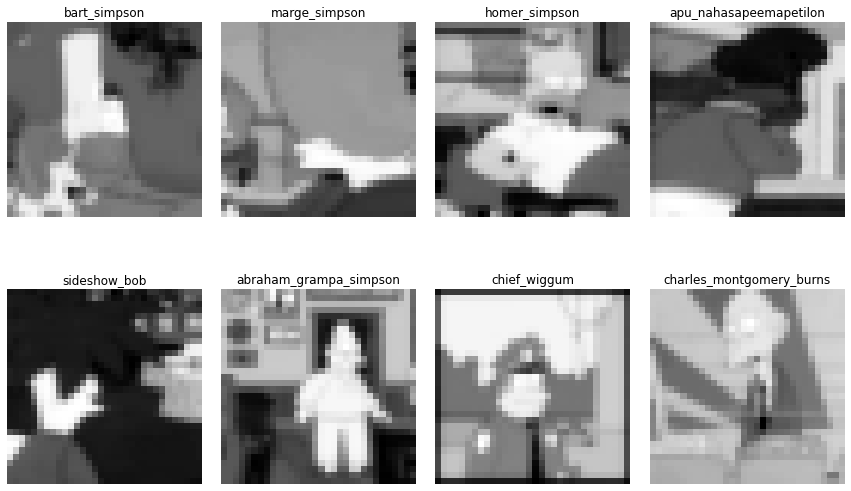

In [10]:
#Dict with settings for image correction
settings_dict = {
    'size' : (32, 32), #resizeing of images
    'grey' : True, #use greyscale
    'gamma_correction' : False, #adjust gamma
    'contrast_correction' : False #adjust contrast
    }

#Load and transform a couple of images to check the quality of the transformed images
su.show_random_images(image_files, labels, char_list_reduced, settings_dict)

- with 32x32 the images lose to much information
- greyscale images also lose to much information

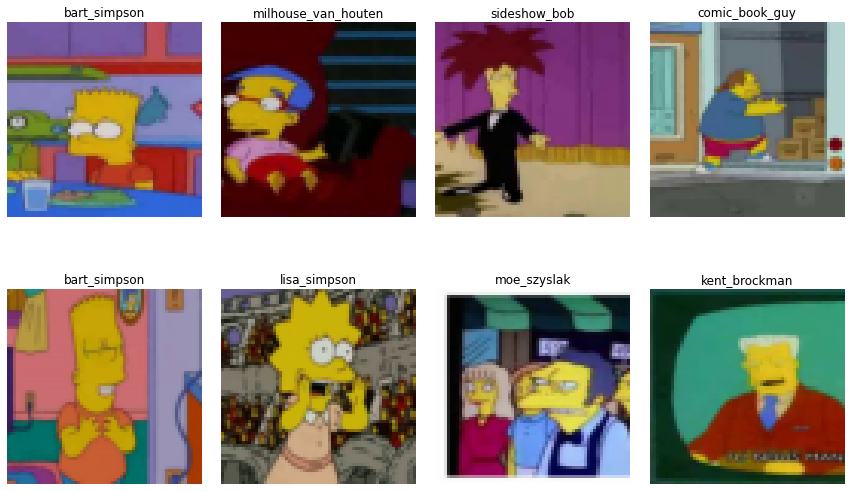

In [11]:
settings_dict = {
    'size' : (64, 64), #resizeing of images
    'grey' : False, #use greyscale
    'gamma_correction' : False, #adjust gamma
    'contrast_correction' : False #adjust contrast
    }
su.show_random_images(image_files, labels, char_list_reduced, settings_dict)

- 64x64 seems good enough

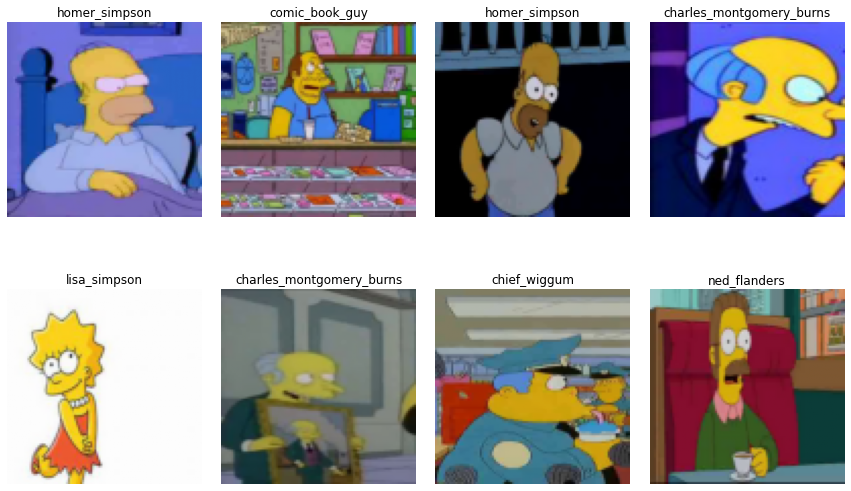

In [12]:
settings_dict = {
    'size' : (96, 96), #resizeing of images
    'grey' : False, #use greyscale
    'gamma_correction' : False, #adjust gamma
    'contrast_correction' : False #adjust contrast
    }
su.show_random_images(image_files, labels, char_list_reduced, settings_dict)

- 96x96 seems even better
- check for runtime problems

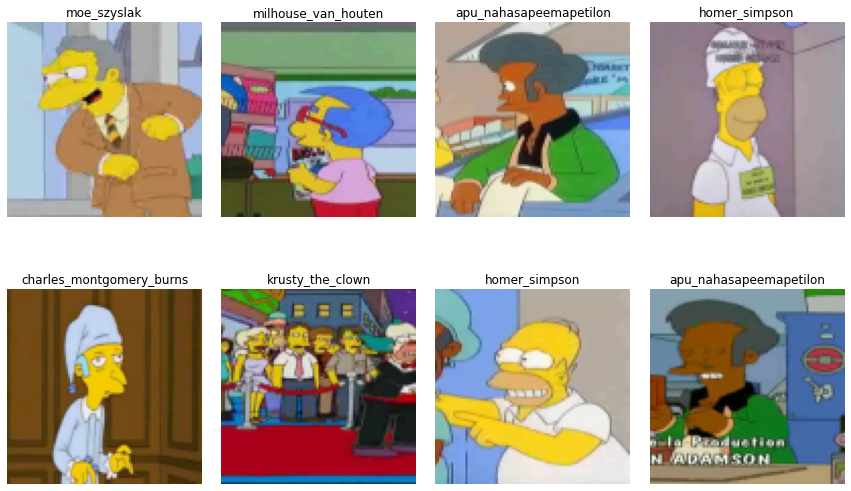

In [13]:
settings_dict = {
    'size' : (96, 96), #resizeing of images
    'grey' : False, #use greyscale
    'gamma_correction' : True, #adjust gamma
    'contrast_correction' : True #adjust contrast
    }
su.show_random_images(image_files, labels, char_list_reduced, settings_dict)

- contrast and gamma correction change not much
- we can omit them

In [14]:
#Save settings_dict for later use by ML-models
settings_dict = {
    'size' : (96, 96), #resizeing of images
    'grey' : False, #use greyscale
    'gamma_correction' : False, #adjust gamma
    'contrast_correction' : False #adjust contrast
    }

with open('settings_dict.json', 'w') as f:
    json.dump(settings_dict, f)